In [1]:
!pip install transformers==3

     |████████████████████████████████| 757kB 9.3MB/s 
     |████████████████████████████████| 901kB 19.5MB/s 
     |████████████████████████████████| 1.2MB 51.7MB/s 
     |████████████████████████████████| 3.0MB 50.1MB/s 


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from tqdm import tqdm


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 23
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
!pip freeze > requirements.txt

In [4]:
data_train = pd.read_csv('/content/Eng_fullTranslated.csv')
data_train.head()

Unnamed: 0  ...  label
0           0  ...    0.0
1           1  ...    0.0
2           2  ...    0.0
3           3  ...    0.0
4           4  ...    0.0

[5 rows x 4 columns]

In [5]:
data_train= data_train.dropna()

In [6]:
data_test = pd.read_csv('/content/test.csv')

In [7]:
#data.drop(['ID','Sub-task B'], axis=1, inplace=True)
data_test.drop(['ID','Sub-task B'], axis=1, inplace=True)



In [8]:
data_train.drop(['Unnamed: 0'], axis=1, inplace=True)

In [9]:
NAG_test = data_test[(data_test['Sub-task A']=='NAG')]
OAG_test= data_test[(data_test['Sub-task A']=='CAG')]
CAG_test = data_test[(data_test['Sub-task A']=='OAG')]

In [10]:
import warnings as wrn
wrn.filterwarnings('ignore')

NAG_test["Sub-task A"] = 0 
#negatives_test["Sentiment"] = 0

OAG_test["Sub-task A"] = 1
#positives_test["Sentiment"] = 2

CAG_test["Sub-task A"] = 2
#neutrals_test["Sentiment"] = 1

NAG_test.head()

Text  Sub-task A
0        U deserve more subscribers. U really great.           0
1                                     Nice video....           0
2  sorry if i bother somebody.. iam a defence asp...           0
3  Joker was amazing....it was not glamorised !.....           0
4                                          Nice baro           0

In [ ]:
data_test

Text Sub-task A
0           U deserve more subscribers. U really great.        NAG
1                                        Nice video....        NAG
2     sorry if i bother somebody.. iam a defence asp...        NAG
3     Joker was amazing....it was not glamorised !.....        NAG
4                                             Nice baro        NAG
...                                                 ...        ...
1061  Ranu Mandal is third class [woman.No](http://w...        OAG
1062  [15:23](https://www.youtube.com/watch?v=N_ZMfQ...        NAG
1063                              Love u bro keep it up        NAG
1064                                    May I help you?        NAG
1065  You are great sir !!! When a i saw a movie fir...        NAG

[1066 rows x 2 columns]

In [11]:
data_test = pd.concat([NAG_test,
                  OAG_test,
                  CAG_test
                 ],axis=0)

In [12]:
data_test = data_test.rename(columns = {'Sub-task A': 'label'}, inplace = False)

In [13]:
train, test = train_test_split(data_test, test_size=0.1, random_state=23)
train, val = train_test_split(data_train, test_size=0.3,random_state=23)

In [14]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [15]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [16]:
sample_txt = 'you are a bad person , and you do not deserve good things'

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: you are a bad person , and you do not deserve good things
   Tokens: ['you', 'are', 'a', 'bad', 'person', ',', 'and', 'you', 'do', 'not', 'deserve', 'good', 'things']
Token IDs: [1128, 1132, 170, 2213, 1825, 117, 1105, 1128, 1202, 1136, 10026, 1363, 1614]


In [17]:
tokenizer.special_tokens_map

{'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

In [18]:
class_names = ['NAG', 'OAG', 'CAG']

In [19]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  1128,  1132,   170,  2213,  1825,   117,  1105,  1128,  1202,
         1136, 10026,  1363,  1614,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [20]:
class GPDataset(Dataset):
  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.comments)
  def __getitem__(self, item):
    comment = str(self.comments[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      comment,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'comment_text': comment,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [22]:
df_train, df_test = train_test_split(
  data_train,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [23]:
df_train.shape, df_val.shape, df_test.shape

((9050, 3), (503, 3), (503, 3))

In [24]:
MAX_LEN = 150

In [25]:
import logging
logging.basicConfig(level=logging.ERROR)

In [26]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPDataset(
    comments=df.Text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(data_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [27]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'targets'])

In [28]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [29]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [30]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [31]:
last_hidden_state.shape
torch.Size([1, 32, 768])

torch.Size([1, 32, 768])

In [32]:
bert_model.config.hidden_size


768

In [33]:
class Classifier(nn.Module):
  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [34]:
model = Classifier(len(class_names))
model = model.to(device)

In [35]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


In [36]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5276, 0.1826, 0.2898],
        [0.4287, 0.2569, 0.3144],
        [0.6725, 0.1413, 0.1862],
        [0.5612, 0.2596, 0.1792],
        [0.5911, 0.2210, 0.1880],
        [0.2703, 0.2193, 0.5105],
        [0.5058, 0.2168, 0.2774],
        [0.3889, 0.2878, 0.3234],
        [0.4417, 0.3561, 0.2021],
        [0.6127, 0.2096, 0.1777],
        [0.5807, 0.1894, 0.2299],
        [0.4345, 0.3306, 0.2349],
        [0.5134, 0.1581, 0.3285],
        [0.2912, 0.4317, 0.2771],
        [0.4099, 0.3341, 0.2560],
        [0.3921, 0.3079, 0.2999]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [37]:
EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [38]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [39]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [40]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/30
----------
Train loss 0.6896861764625399 accuracy 0.7045303867403315
Val   loss 0.584408272523433 accuracy 0.7534791252485089

Epoch 2/30
----------
Train loss 0.4786312255165918 accuracy 0.8045303867403315
Val   loss 0.6162025108933449 accuracy 0.7773359840954274

Epoch 3/30
----------
Train loss 0.31419369466306624 accuracy 0.8850828729281768
Val   loss 0.7926578866317868 accuracy 0.7753479125248508

Epoch 4/30
----------
Train loss 0.18968621126557914 accuracy 0.9414364640883978
Val   loss 1.1343510011211038 accuracy 0.7574552683896619

Epoch 5/30
----------
Train loss 0.11587586725630893 accuracy 0.970828729281768
Val   loss 1.3940239073708653 accuracy 0.7594433399602385

Epoch 6/30
----------
Train loss 0.08157483308103804 accuracy 0.9808839779005525
Val   loss 1.6778095597401261 accuracy 0.7435387673956262

Epoch 7/30
----------
Train loss 0.050761742909122574 accuracy 0.9892817679558011
Val   loss 1.7381052505224943 accuracy 0.7475149105367792

Epoch 8/30
----------
T

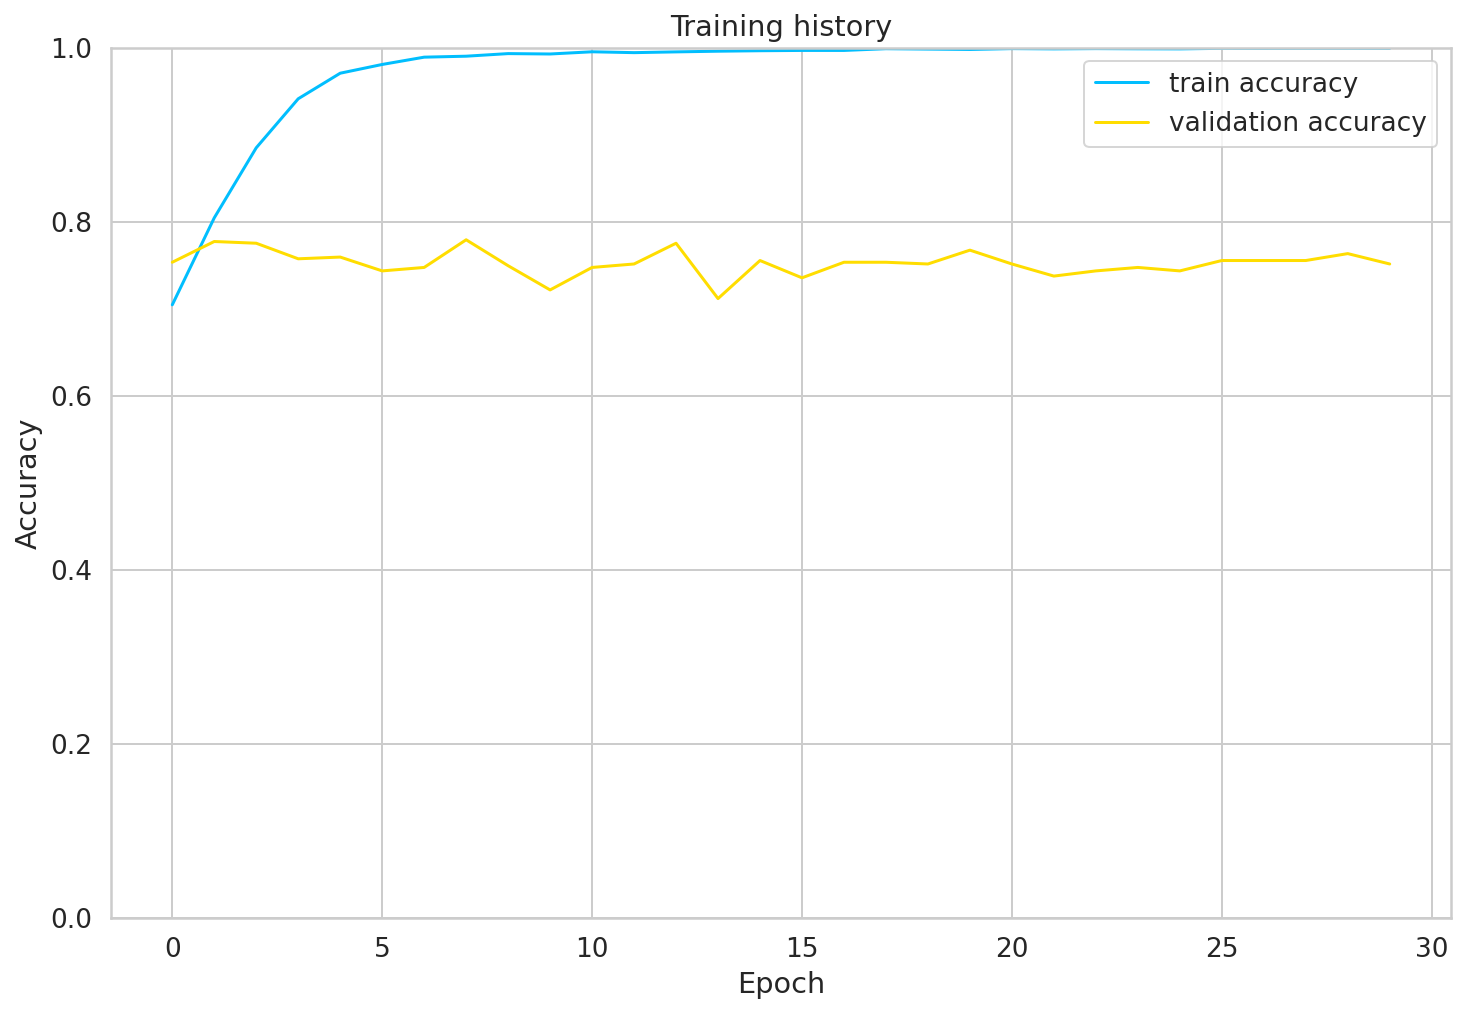

In [41]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

In [43]:
def get_predictions(model, data_loader):
  model = model.eval()
  comment_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["comment_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      comment_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return comment_texts, predictions, prediction_probs, real_values

In [44]:
y_comment_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [45]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         NAG       0.88      0.88      0.88       836
         OAG       0.35      0.39      0.37       117
         CAG       0.47      0.42      0.44       113

    accuracy                           0.78      1066
   macro avg       0.57      0.56      0.56      1066
weighted avg       0.78      0.78      0.78      1066



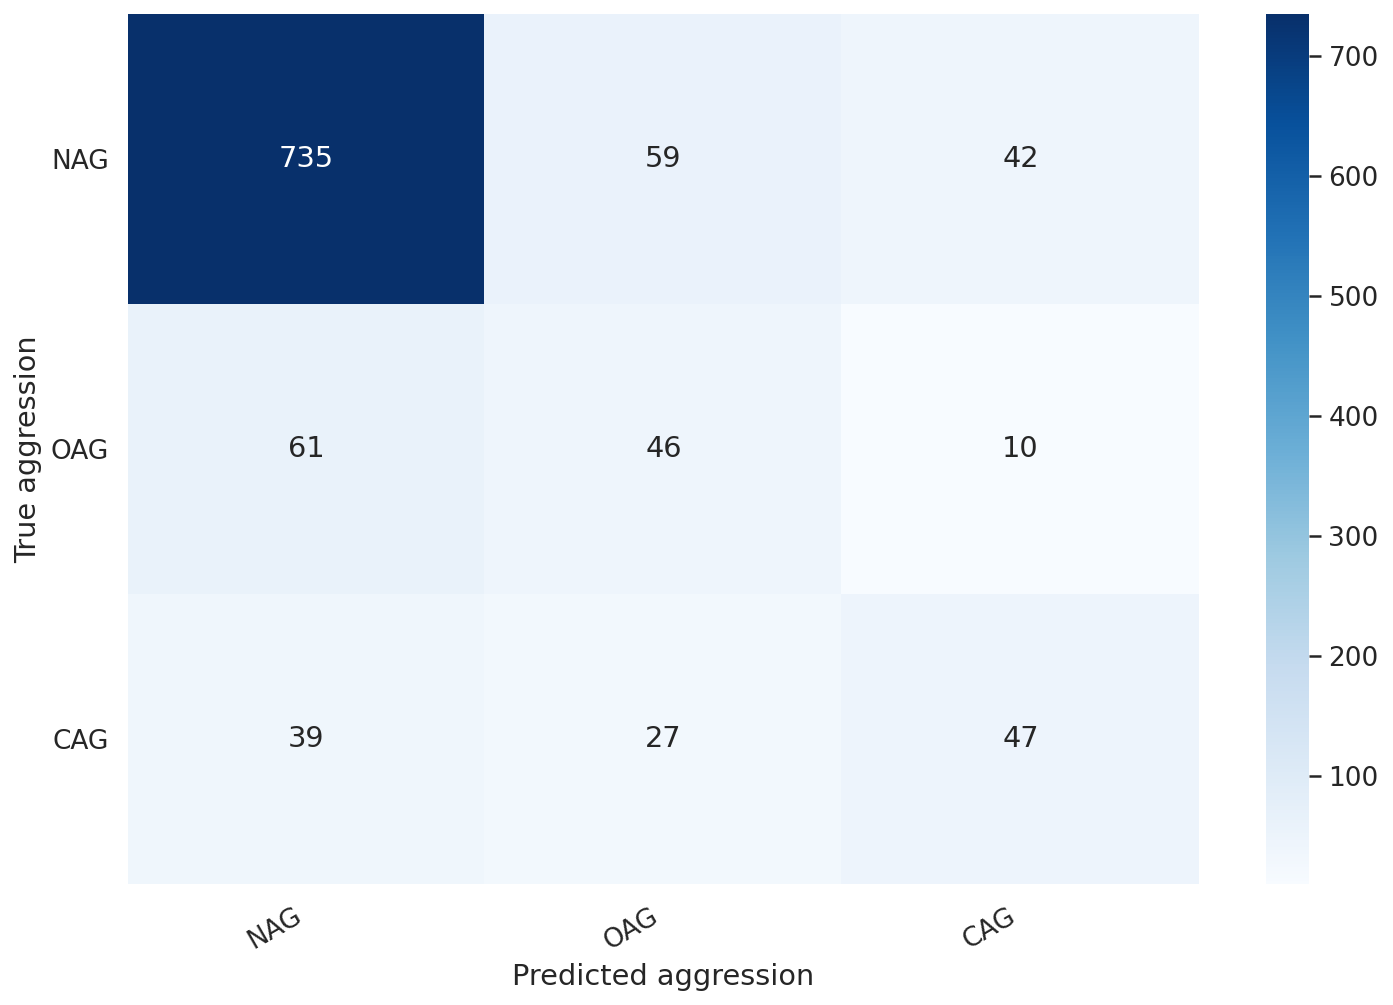

In [46]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True aggression')
  plt.xlabel('Predicted aggression');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [47]:
idx = 2
comment_text = y_comment_texts[idx]
true_aggression = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [48]:
print("\n".join(wrap(comment_text)))
print()
print(f'True aggression: {class_names[true_aggression]}')

sorry if i bother somebody.. iam a defence aspirant..   and i think
that homosexual shouldn't be allowed to join army as a general duty
personnel as we know that a different kind of atmosphere is there..
they have a very harsh routine there... abusing,hard workouts
unbearable pain unbearable punishment and manhandling for severe
mistakes(mainly in probation period) is normal... when such type of
thing will happen to them they could get a feeling of
discrimination(which is clearly not) however they can join clerical
medical supply signal corps as upper mention hardness is of less
magnitude there...

True aggression: NAG


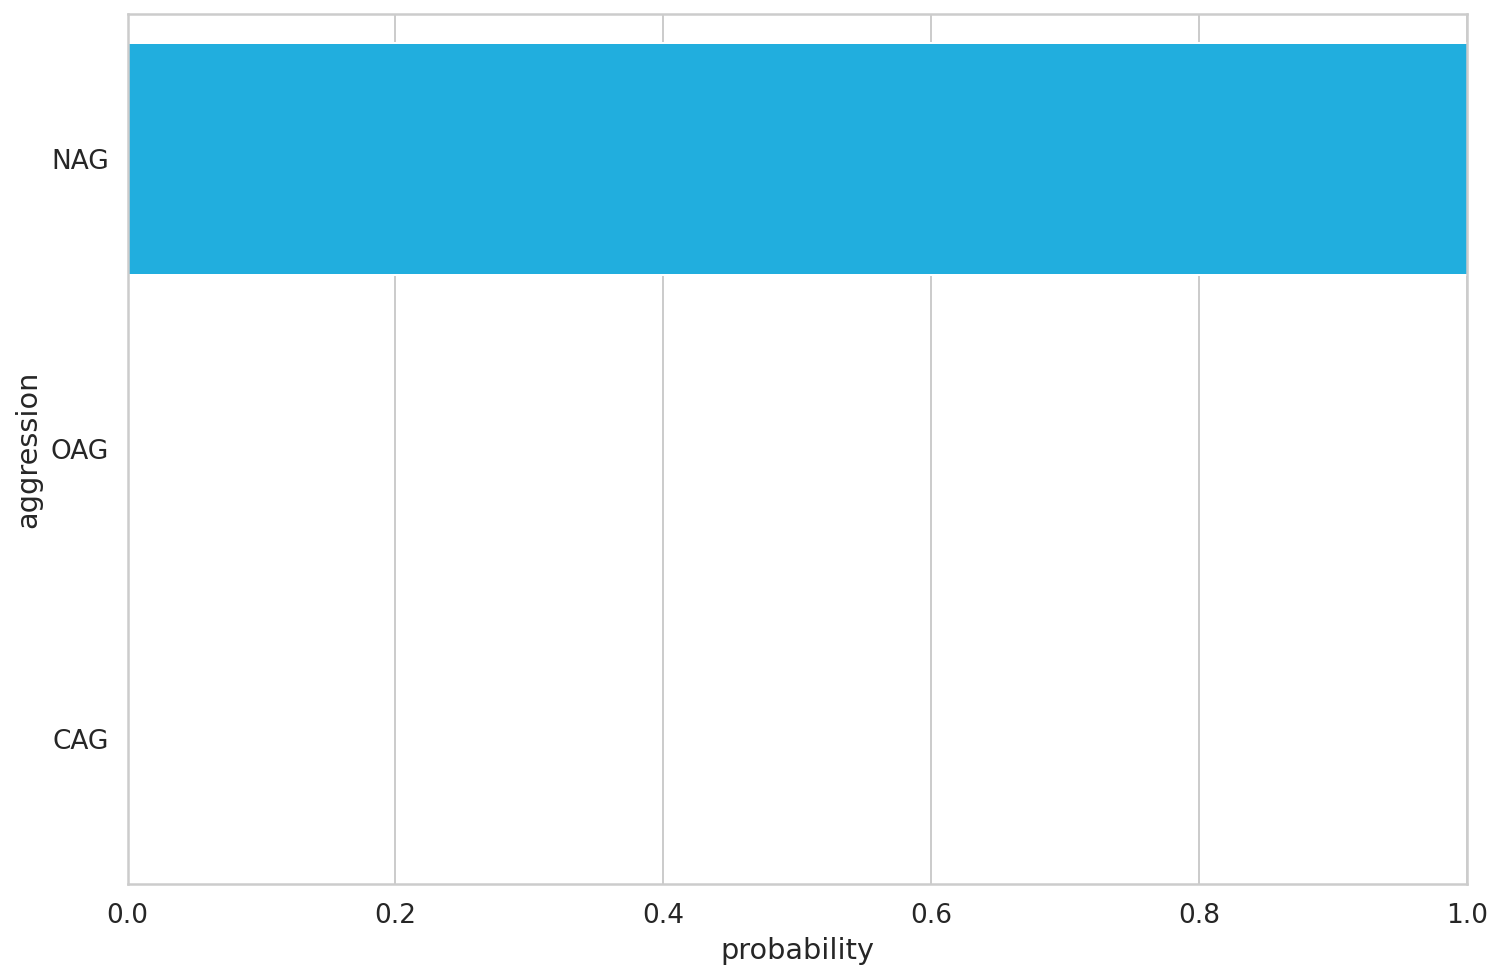

In [49]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('aggression')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [50]:
comment_text = "she is a little girl but looks so angry!"

In [51]:
encoded_comment= tokenizer.encode_plus(
  comment_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [52]:
input_ids = encoded_comment['input_ids'].to(device)
attention_mask = encoded_comment['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'comment text: {comment_text}')
print(f'aggression  : {class_names[prediction]}')


comment text: she is a little girl but looks so angry!
aggression  : NAG
